# Macro fit

This notebook is old. You can ignore it for now. It uses the default lenstronomy MCMC rather than `emcee`.

---

This notebook is similar to `lensfit.ipynb`, but here we'll be focusing on just fitting a simple macro model (whether or not there is actual substructure).

In [1]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cms
%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
import lenstronomy.Plots.output_plots as lens_plot
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

import copy

In [2]:
def ADD(z1,z2):
    ## This is a function that computes the angular diameter distance
    ## between two redshifts z1 and z2.
    cosmo = FlatLambdaCDM(H0=70, Om0=0.316) 
    return cosmo.angular_diameter_distance_z1z2(z1,z2)

def sigma_cr(zd,zs):
    ## This function calculates the critical surface mass density at
    ## redshift zd, relative to the source redshift zs.
    const = 1.663e18*u.M_sun / u.Mpc##c^2/(4 pi G)
    return const*(ADD(0,zs)/(ADD(zd,zs)*ADD(0,zd))) ##in units Msun/Mpc^2

def gfunc(c):
    ## This is the g(c) function that is defined
    ## commonly in NFW profiles.
    a = np.log(1.+c) - (c/(1.+c))
    return 1./a

def rs_angle(zd,rs): 
    ##takes in interloper redshift, gives you the scale redius in angular units
    Dd = ADD(0,zd)
    rs_mpc = rs*u.Mpc
    return ((1./4.848e-6)*rs_mpc)/Dd ##gives in arcsec

def alpha_s(m,rs,zd,zs):
    ##takes in subhalo mass, scale radius, interloper redshift, source redshift
    ##returns the angular deflection at scale radius
    m_msun = m*u.M_sun
    rs_mpc = rs*u.Mpc
    con = (1./np.pi)*gfunc(200.)*(1.-np.log(2))
    return (con*m_msun)/((rs_mpc**2.)*sigma_cr(zd,zs))

def k_ext(N,m,A,zd,zs,pixsize):
    ## FOR NOW THIS IS SET TO ZERO BECAUSE I CAN'T GET IT TO WORK
    m_msun = m*u.M_sun
    A_mpc2 = (pixsize**4)*(ADD(0.,zd)**2.)*A*((4.848e-6)**2.)  ##arcsec conversion
    return 0.##-(N*m_msun)/(A_mpc2*sigma_cr(zd,zs))


def xi_to_x(xi,z):
    ##takes in physical coordinates (Mpc), turns it into angular coordinates (arcsec)
    x = np.array(((xi*u.Mpc)/ADD(0.,z))/4.848e-6)
    y = x.astype(np.float)
    return y

def x_to_xi(x,z):
    ##takes in angular coordinates (arcsec), turns it into physical coordinates (Mpc)
    return ((x*4.848e-6)*ADD(0,z))/u.Mpc

def xi_to_pix(xi,z,pixsize,pixnum):
    ## takes in physical coordinates (Mpc), identifies the appropriate pixel number
    return (xi_to_x(xi,z))/pixsize + pixnum/2.
def inv_rs_angle(zd,rs_angle):
    ## takes in the rs angle in arcsec gives rs in in MPC
    Dd = ADD(0,zd)
    return 4.848e-6*Dd*rs_angle


def inv_alpha_s(alpha_s,rs,zd,zs):
    ## takes in subhalo angular deflection at scale radius, scale radius,
    ## interloper redshift and source redshift and returns interloper mass
    rs_mpc = rs*u.Mpc
    con = (1./np.pi)*gfunc(200.)*(1.-np.log(2))
    return (alpha_s/con)*((rs_mpc**2.)*sigma_cr(zd,zs))

# Generate image

First, set the constants:

In [3]:
## REDSHIFTS #######################################################################################
Nit = 100 ##Number of different redshifts
zds = np.linspace(0.01,0.99,Nit)
####################################################################################################



## SOURCE PROPERTIES ###############################################################################
r_sersic_source = 10.0
e1s, e2s = param_util.phi_q2_ellipticity(phi=0.8, q=0.2)
beta_ras, beta_decs = [1.7],[0.3]#this is the source position on the source plane

n_sersic_source = 1.5

## SOURCE-CLUMP PROPERTIES #########################################################################
r_sersic_source_clumps = 1/3.
N_clump = 0
clumprandx = np.random.rand(N_clump)
clumprandy = np.random.rand(N_clump)

source_scatter = 1. ## This is how wide the scatter of the clumps over the smooth source

n_sersic_source_clumps = 1.5

####################################################################################################



## LENS PROPERTIES #################################################################################
theta_lens = 10.
zl = 0.2
r_theta_lens = x_to_xi(theta_lens,zl)
e1, e2 = param_util.phi_q2_ellipticity(phi=-0.9, q=0.8)
gamma = 2.

center_lens_x, center_lens_y = 0.,0.
####################################################################################################



## IMAGE PROPERTIES ################################################################################
pixsize = 0.2
####################################################################################################



## INTERLOPER PROPERTIES ########################################################################### 
N = 0 ##Number of perturbers
M = 1 ##Averaging different realizations

disc_size = 2. ##  interlopers are randomly distributed to a disk that is this
               ##  this times bigger than the einstein radius of the lens
# Perturbers are uniformly distributed within a disk of radius `disc_size * r_theta_lens`
r2s = ((disc_size*r_theta_lens)**2.)*(np.random.rand(N,M))
rss = np.sqrt(r2s)
theta_p = 2.*np.pi*(np.random.rand(N,M))
xs = rss*np.cos(theta_p)
ys = rss*np.sin(theta_p)
xpixs = np.zeros([Nit,N,M]) # will add pixel values in the next cell
ypixs = np.zeros([Nit,N,M]) #
####################################################################################################

Then, calculate the image:

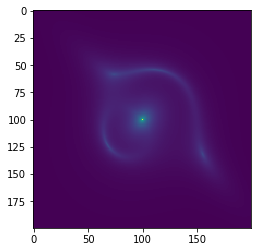

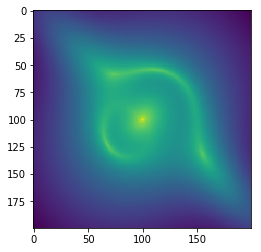

In [175]:
j = 19 # arbitrary choice (loop over redshifts)
k = 0 # also arbitrary choice (loop over statistics)

beta_ra, beta_dec = beta_ras[0], beta_decs[0]

xpixs[j] = xi_to_pix(xs,zds[j],pixsize,200)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
ypixs[j] = xi_to_pix(ys,zds[j],pixsize,200)   ## POSITIONS. (THEY ARE RANDOMLY GENERATED IN THE EARLIER BOX)

m =1.0e7 # mass of interlopers
if j == 0:
    m = 0. # so that the first image will be pure (no interloper effect)
zs = 1.
zd = zds[j] # interloper redshift
rs = 0.001  # interloper scale radius r_s
A = 80**2 ## in arcsec ## IGNORE THIS, THIS WAS FOR NEGATIVE CONVERGENCE

kext = float(k_ext(N,m,A,zl,zs,pixsize))
rsang = float(rs_angle(zd,rs))
alphars = float(alpha_s(m,rs,zd,zs))

## Setting lens_model_list and redshift_list
lens_model_main = ['SPEP']
lens_model_interlopers = ['CONVERGENCE']+['NFW' for i in range(N)]
redshift_main = [zl]
redshift_interlopers = [zd]+[zd for i in range(N)]
# (unfortunately, we need to give the redshifts in increasing order, so we have two cases)
if zl >= zd:
    lens_model_list = lens_model_interlopers + lens_model_main
    redshift_list = redshift_interlopers + redshift_main
else:
    lens_model_list = lens_model_main + lens_model_interlopers
    redshift_list = redshift_main + redshift_interlopers


z_source = zs

lensModel_mp = LensModel(lens_model_list=lens_model_list,
                         z_source=z_source,
                         lens_redshift_list=redshift_list, 
                         multi_plane=True)

kwargs_spep = {'theta_E': theta_lens, 'e1': e1, 'e2': e2, 
               'gamma': gamma, 'center_x': center_lens_x, 'center_y': center_lens_y}
kwargs_conv ={'kappa_ext': kext}

### NFW kwargs for the interlopers
kwargs_main_lens = [kwargs_spep]
kwargs_interlopers = [kwargs_conv] # (+ will append interlopers)
for i in range(N):
    center_nfw_x = xi_to_x(xs[i,k],zd)
    center_nfw_y = xi_to_x(ys[i,k],zd)

    kwargs_nfw = {'Rs':rsang,'alpha_Rs':alphars,'center_x': center_nfw_x, 'center_y': center_nfw_y}
    kwargs_interlopers.append(kwargs_nfw)

# (again, need to sort by redshift)
if zl >= zd:
    kwargs_lens = kwargs_interlopers + kwargs_main_lens
else:
    kwargs_lens = kwargs_main_lens + kwargs_interlopers

########################################################################
# set up the list of light models to be used #

# SOURCE light
source_light_model_list = ['SERSIC_ELLIPSE']
for i in range(N_clump):
    source_light_model_list.append('SERSIC')

lightModel_source = LightModel(light_model_list = source_light_model_list)

# LENS light
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list = lens_light_model_list)

# SOURCE light kwargs
kwargs_light_source = [{'amp': 1000., 'R_sersic': r_sersic_source, 'n_sersic': n_sersic_source, 
                      'e1': e1s, 'e2': e2s, 'center_x': beta_ra , 'center_y': beta_dec}]
for i in range(N_clump):
    kwargs_light_source.append({'amp': 1000, 'R_sersic': r_sersic_source_clumps, 'n_sersic': n_sersic_source_clumps,
                                'center_x': beta_ra+source_scatter*(clumprandx[i]-.5), 
                                'center_y': beta_dec+source_scatter*(clumprandy[i]-.5)})

# LENS light kwargs
kwargs_light_lens = [{'amp': 1500, 'R_sersic': theta_lens, 'n_sersic': gamma, 
                      'e1': e1, 'e2': e2, 'center_x': center_lens_x , 'center_y': center_lens_y}]

# evaluate surface brightness at a specific position #
#flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

deltaPix = pixsize ###aLSO PIXSIze size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -20, -20 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 200, 'ny': 200,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #

kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.01,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel correspon
kernel = psf.kernel_point_source

####################################################################################

# import the ImageModel class #

# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_mp,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)

plt.imshow(image); plt.show()
plt.imshow(np.log(image)); plt.show()

In [176]:
## Noisy Image #####################################################################
exp_time = 100  # exposure time to quantify the Poisson noise level (what units?)
background_rms = 0.1  # background rms value
poisson = image_util.add_poisson(image, exp_time=exp_time)
bkg = image_util.add_background(image, sigma_bkd=background_rms)
image_noisy = image + bkg + poisson
# plt.imshow(image_noisy); plt.show()
# plt.imshow(np.log(image_noisy)); plt.show()

## Macro model

Fit image to macro model.

*(work in progress)*

## Parameters
What are the parameters we have to fit?

In [177]:
gamma

2.0

In [178]:
def get_mcmc_kwargs_lens():
    # returns kwargs_lens-related list of dictionaries for MCMC
    
    # Remember:
    # 0: init, 1: sigma, 2: fixed, 3: lower, 4: upper !
    
    # We will set up the list for each type of lens like this:
    spep = [None] * 5
    
    if zl >= zd:
        spep[0] = [kwargs_lens[-1]] # [interlopers, CONV, SPEP]
    else:
        spep[0] = [kwargs_lens[1]] # [CONV, SPEP, interlopers]
    
    spep[1] = [{'e1': .0001, 'e2': 0.0001,
                'theta_E':.01,
              'center_x': .01, 'center_y': .01}]
    spep[2] = [{'gamma':2}]
    spep[3] = [{'e1': -1, 'e2':-1,
                'theta_E':0,
                'center_x': -10, 'center_y': -10}]
    spep[4] = [{'e1': 1, 'e2': 1,
                 'theta_E':20,
                'center_x': 10, 'center_y': 10}]
    
    return spep

In [179]:
def get_mcmc_kwargs_light_source():
    # returns a kwargs_light_source-related list
    #   of dictionaries as input for MCMC
    
    # secret inputs: (to fill in later)
    
    # Remember:
    # 0: init, 1: sigma, 2: fixed, 3: lower, 4: upper !
    
    source = [[{}] for _ in range(5)]
    source[2] = [{'R_sersic': 10.0,
                  'amp': 1000.0,
                  'center_x': 1.7,
                  'center_y': 0.3,
                  'e1': -0.019466348200859213,
                  'e2': 0.6663824020276702,
                  'n_sersic': 1.5}]
    return source

In [180]:
# def get_mcmc_kwargs_light_lens():
#     # returns a kwargs_light_lens-related list of dicts as input for MCMC
    
#     # secret inputs: (to fill in later)
    
#     # Remember:
#     # 0: init, 1: sigma, 2: fixed, 3: lower, 4: upper !
    
#     light = [[{}] for _ in range(5)]
    
#     light[2] = [{'R_sersic': theta_lens,
#           'amp': 1500,
#           'center_x': 0.0,
#           'center_y': 0.0,
#           'e1': e1,
#           'e2': e2,
#           'n_sersic': gamma}]
    
#     return light

## Observational kwargs
`kwargs_data_joint` seems to be about observational effects.

In [209]:
# kwargs_data = {'image_data': image_noisy,
#                'background_rms': background_rms,
#                'exposure_time': exp_time,
#                'ra_at_xy_0': ra_at_xy_0,  
#                'dec_at_xy_0': dec_at_xy_0,
#                'transform_pix2angle': transform_pix2angle}

kwargs_data = {'image_data': image_noisy,
               'background_rms': background_rms,
               'exposure_time': exp_time,
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle}

single_band = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': single_band, 'multi_band_type': 'multi-linear'} 

## Other kwargs

In [210]:
lens_model_fit = ['SPEP']

kwargs_params = {'lens_model': get_mcmc_kwargs_lens(),
                 'source_model': get_mcmc_kwargs_light_source()}
                 #'lens_light_model': get_mcmc_kwargs_light_lens()}
kwargs_constraints = {}
kwargs_likelihood = {'source_marg':False}

kwargs_model = {'lens_model_list':lens_model_fit, 'source_light_model_list':source_light_model_list}

## Fitting Seq

In [211]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model,
                              kwargs_constraints, kwargs_likelihood, kwargs_params)

In [227]:
%%time
fitting_kwargs_list = [['MCMC', {'n_burn':1, 'n_run':30, 'walkerRatio':10, 'sigma_scale':.01}]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

1500 5 5 shape of init_sample
re-using previous samples to initialize the next MCMC run.
Computing the MCMC...
Number of walkers =  50
Burn-in iterations:  1
Sampling iterations: 30
46.486754417419434 time taken for MCMC sampling
CPU times: user 3min 24s, sys: 2min 35s, total: 6min
Wall time: 46.5 s


In [228]:
# import pickle

# with open('chains.p', 'wb') as f:
#     pickle.dump(chain_list, f)

In [229]:
chain_list

[['EMCEE', array([[ 1.00000601e+01, -2.52441099e-02, -1.08205896e-01,
           6.10995484e-05,  8.31927933e-05],
         [ 1.00001403e+01, -2.52423900e-02, -1.08205712e-01,
           3.97998950e-06, -1.34593633e-04],
         [ 1.00001392e+01, -2.52448012e-02, -1.08206598e-01,
          -7.68614950e-05, -8.10322947e-05],
         ...,
         [ 9.96601485e+00, -2.58196406e-02, -1.08199950e-01,
           1.35630581e-02,  1.34185576e-02],
         [ 1.00000133e+01, -2.52429423e-02, -1.08205694e-01,
           3.45464760e-04,  3.16257845e-04],
         [ 9.99919551e+00, -2.52385217e-02, -1.08162144e-01,
           7.31430068e-03,  6.27222576e-03]]), ['theta_E_lens0',
   'e1_lens0',
   'e2_lens0',
   'center_x_lens0',
   'center_y_lens0'], array([-2.09537587e+09, -2.12974617e+09, -2.09852107e+09, ...,
         -2.06778331e+09, -2.09273981e+09, -2.09105816e+09])]]

In [230]:
nvars = len(chain_list[0][2])

In [231]:
kwargs_lens

[{'kappa_ext': 0.0},
 {'center_x': 0.0,
  'center_y': 0.0,
  'e1': -0.025244677188120783,
  'e2': -0.10820529231979943,
  'gamma': 2.0,
  'theta_E': 10.0}]

0 theta_E_lens0


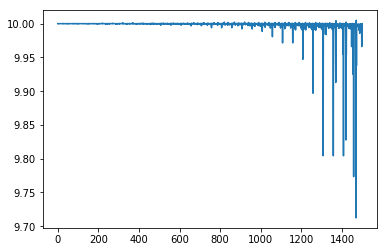

1 e1_lens0


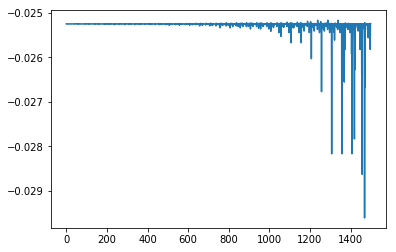

2 e2_lens0


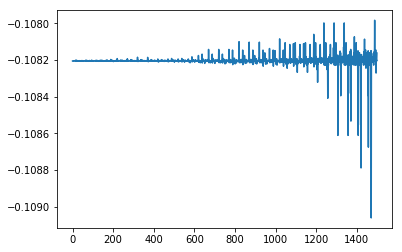

3 center_x_lens0


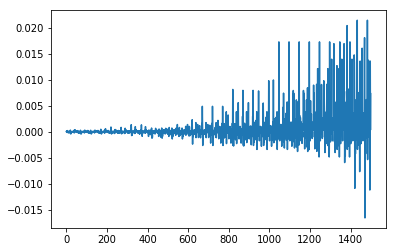

4 center_y_lens0


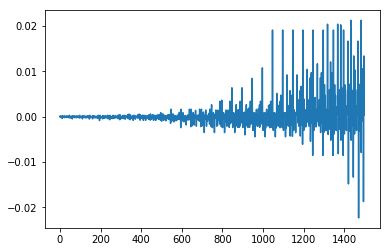

In [232]:
for i, var in enumerate(chain_list[0][2]):
    print(i, var)
    plt.plot(chain_list[0][1][:,i])
    plt.show()

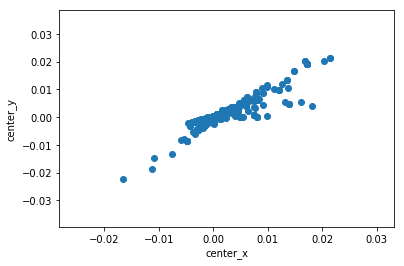

In [233]:
plt.scatter(chain_list[0][1][:,3], chain_list[0][1][:,4])
plt.xlabel('center_x')
plt.ylabel('center_y')
plt.show()

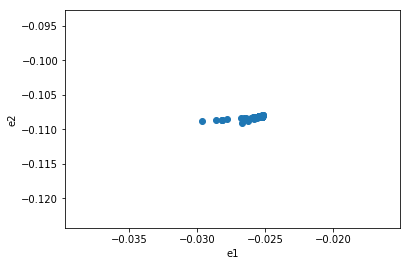

In [234]:
plt.scatter(chain_list[0][1][:,1], chain_list[0][1][:,2])
plt.xlabel('e1')
plt.ylabel('e2')
plt.show()

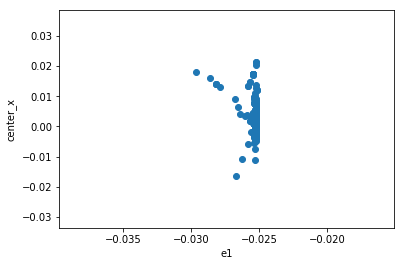

In [235]:
plt.scatter(chain_list[0][1][:,1], chain_list[0][1][:,3])
plt.xlabel('e1')
plt.ylabel('center_x')
plt.show()

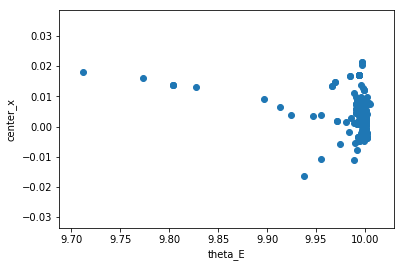

In [236]:
plt.scatter(chain_list[0][1][:,0], chain_list[0][1][:,3])
plt.xlabel('theta_E')
plt.ylabel('center_x')
plt.show()

### Reconstructing the image

In [237]:
def error(image1, image2):
    assert(image1.shape == image2.shape)
    return np.sum((image1 - image2)**2)

In [238]:
lensModel_fit = LensModel(lens_model_list=lens_model_fit,
                                 z_source=z_source,
                                 multi_plane=False)

imageModel_fit = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_fit,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        kwargs_numerics=kwargs_numerics)

{'center_x_lens0': 0.0027949245189189775, 'theta_E_lens0': 9.985615435210468, 'center_y_lens0': 0.0016868074295247673, 'e2_lens0': -0.10822987616816614, 'e1_lens0': -0.025458920654326533}
[{'e2': array(-0.10822988), 'theta_E': array(9.98561544), 'e1': array(-0.02545892), 'center_y': array(0.00168681), 'gamma': array(2), 'center_x': array(0.00279492)}]


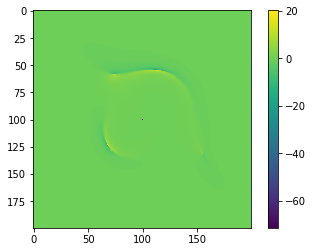

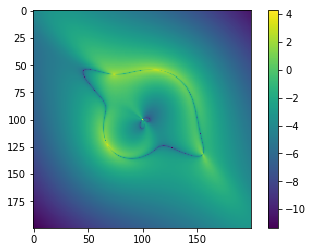

'26214.2'

In [239]:
# Fit to average of last 100 iterations/walkers of MCMC #

fitdico = {}
for key, val in zip(chain_list[0][2], chain_list[0][1].T):
    fitdico[key] = np.mean(val[-100:]) # this is arbitrary, of course!
print(fitdico)

fitdico['gamma_lens0'] = 2

kwargs_lens_fit = copy.deepcopy(get_mcmc_kwargs_lens()[0])
for key in kwargs_lens_fit[0]:
    kwargs_lens_fit[0][key] = np.array(fitdico[key+'_lens0'])
print(kwargs_lens_fit)
    
# simulate image with the "fitted" parameters #
image_fit = imageModel_fit.image(kwargs_lens=kwargs_lens_fit,
                                      kwargs_source=kwargs_light_source,
                                      kwargs_lens_light=kwargs_light_lens)
#, kwargs_ps=kwargs_ps)

plt.imshow(image_fit-image); plt.colorbar(); plt.show()
plt.imshow(np.log(abs(image_fit-image))); plt.colorbar(); plt.show()
'%g' % error(image, image_fit)

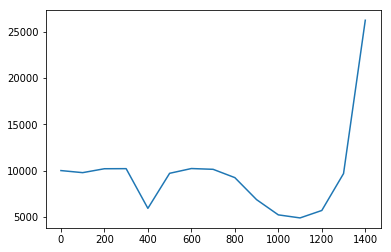

In [240]:
# Error as a function of MCMC time #

segments = np.arange(0,len(chain_list[0][1]), 100)

errors = []

for segment in segments:
    fitdico = {}
    for key, val in zip(chain_list[0][2], chain_list[0][1].T):
        fitdico[key] = np.mean(val[segment:segment+100]) # this is arbitrary, of course!
    fitdico['gamma_lens0'] = 2

    kwargs_lens_fit = copy.deepcopy(get_mcmc_kwargs_lens()[0])
    for key in kwargs_lens_fit[0]:
        kwargs_lens_fit[0][key] = np.array(fitdico[key+'_lens0'])
    #print(kwargs_lens_fit)

    # simulate image with the "fitted" parameters #
    image_fit = imageModel_fit.image(kwargs_lens=kwargs_lens_fit,
                                          kwargs_source=kwargs_light_source,
                                          kwargs_lens_light=kwargs_light_lens)

    errors.append( error(image, image_fit) )

# error as a function of MCMC iteration -- why is it increasing?
plt.plot(segments, errors)

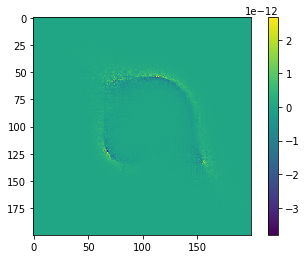

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


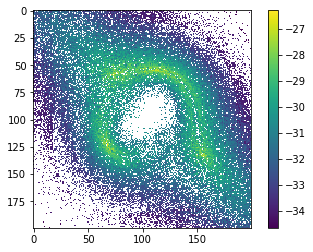

5.311400821951871e-22

In [241]:
# Initial parameters but not interlopers #
kwargs_lens_same = get_mcmc_kwargs_lens()[0]
image_samekwargs = imageModel_fit.image(kwargs_lens=kwargs_lens_same,
                                            kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)

plt.imshow(image_samekwargs-image); plt.colorbar(); plt.show()
plt.imshow(np.log(abs(image_samekwargs-image))); plt.colorbar(); plt.show()
error(image, image_samekwargs)

fit vs init {'e2': (-0.10820194403468332, -0.10820529231979943), 'theta_E': (9.99849694972415, 10.0), 'e1': (-0.025259369219219202, -0.025244677188120783), 'center_y': (0.0012600222170545126, 0.0), 'gamma': (2.0, 2.0), 'center_x': (0.0014143896546380268, 0.0)}


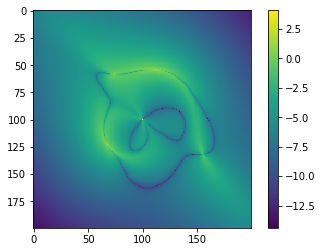

error 0.004030379634485179 million
fit vs init {'e2': (-0.10820048163530759, -0.10820529231979943), 'theta_E': (9.99878537219043, 10.0), 'e1': (-0.025237544619170025, -0.025244677188120783), 'center_y': (0.00045926078463267596, 0.0), 'gamma': (2.0, 2.0), 'center_x': (0.00046174598692131074, 0.0)}


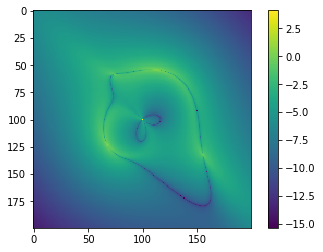

error 0.0038912836655002375 million
fit vs init {'e2': (-0.10820805966133816, -0.10820529231979943), 'theta_E': (9.999396518287838, 10.0), 'e1': (-0.025254757566647523, -0.025244677188120783), 'center_y': (-0.0006284046285340005, 0.0), 'gamma': (2.0, 2.0), 'center_x': (-0.00037537160185015326, 0.0)}


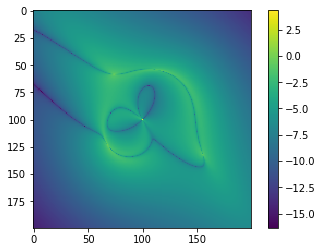

error 0.005689891991215654 million
fit vs init {'e2': (-0.10814477634585688, -0.10820529231979943), 'theta_E': (9.999036530692662, 10.0), 'e1': (-0.025240636449028523, -0.025244677188120783), 'center_y': (0.0030311102598948865, 0.0), 'gamma': (2.0, 2.0), 'center_x': (0.003879826442430805, 0.0)}


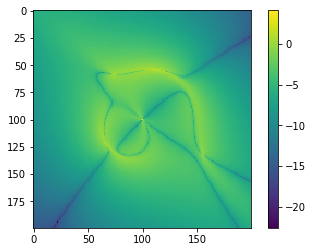

error 0.004630885537227489 million
fit vs init {'e2': (-0.10819923519956269, -0.10820529231979943), 'theta_E': (9.999133863630046, 10.0), 'e1': (-0.025249836815592203, -0.025244677188120783), 'center_y': (0.000785620168047854, 0.0), 'gamma': (2.0, 2.0), 'center_x': (0.0009049605757820541, 0.0)}


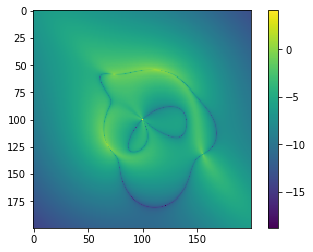

error 0.003737954511092678 million
fit vs init {'e2': (-0.10827139997193841, -0.10820529231979943), 'theta_E': (9.989125244209674, 10.0), 'e1': (-0.0252810534116108, -0.025244677188120783), 'center_y': (-0.01875539227996125, 0.0), 'gamma': (2.0, 2.0), 'center_x': (-0.011171937832024952, 0.0)}


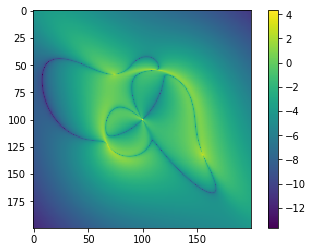

error 0.018532907871159913 million
fit vs init {'e2': (-0.10820153059177605, -0.10820529231979943), 'theta_E': (9.999656204514304, 10.0), 'e1': (-0.02524517462742611, -0.025244677188120783), 'center_y': (0.0010078650882570624, 0.0), 'gamma': (2.0, 2.0), 'center_x': (0.0009584473435813056, 0.0)}


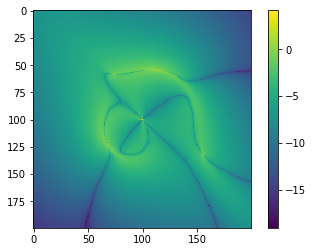

error 0.004047725041270575 million
fit vs init {'e2': (-0.10819994970851894, -0.10820529231979943), 'theta_E': (9.966014847175623, 10.0), 'e1': (-0.025819640599722825, -0.025244677188120783), 'center_y': (0.01341855756575875, 0.0), 'gamma': (2.0, 2.0), 'center_x': (0.013563058070295446, 0.0)}


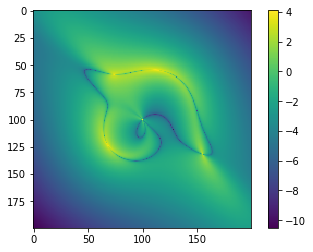

error 0.14897323822189745 million
fit vs init {'e2': (-0.10820569408521316, -0.10820529231979943), 'theta_E': (10.000013260189526, 10.0), 'e1': (-0.025242942334002018, -0.025244677188120783), 'center_y': (0.00031625784514257676, 0.0), 'gamma': (2.0, 2.0), 'center_x': (0.00034546476009415165, 0.0)}


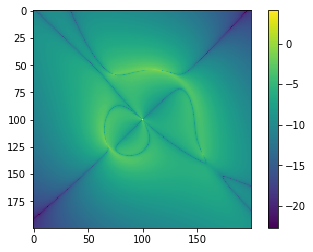

error 0.0036014161899767722 million
avg error 21903.964740425105


In [242]:
# Fit to a single (late) iteration/walker of MCMC!

error_list = []
for idx in range(-10,-1):
    
    kwargs_lens_fit = copy.deepcopy(get_mcmc_kwargs_lens()[0])
    for i, key in enumerate(chain_list[0][2]):
        kwargs_lens_fit[0][key.replace('_lens0','')] = chain_list[0][1][idx,i]
        
    compare_dict = {}
    for key, val in get_mcmc_kwargs_lens()[0][0].items():
        compare_dict[key] = (kwargs_lens_fit[0][key], val)
    
    print('fit vs init', compare_dict)
    
    # simulate image with the "fitted" parameters #
    image_fit = imageModel_fit.image(kwargs_lens=kwargs_lens_fit,
                                          kwargs_source=kwargs_light_source,
                                          kwargs_lens_light=kwargs_light_lens)
    #, kwargs_ps=kwargs_ps)

    plt.imshow(np.log(abs(image_fit-image))); plt.colorbar(); plt.show()
    print('error', error(image, image_fit)/1e6,'million')
    error_list.append(error(image, image_fit))
print('avg error', np.mean(error_list))

In short, this didn't work...

Where is the optimal $(x,y)$ position of our interloper (holding everything else constant)?

In [201]:
# Fit to one "local maximum" of MCMC #

kwargs_lens_fit3 = copy.deepcopy(kwargs_lens)
## just use last value, since they didn't really converge
# chain_list[0][1][val,0], chain_list[0][1][val,1]
val = -1 # take last walker iteration
kwargs_lens_fit3[2]['center_x'] = np.array(np.mean(xs_second))
kwargs_lens_fit3[2]['center_y'] = np.array(np.mean(ys_second))
# kwargs_lens_fit2[3]['center_x'] = np.array(fitdico['center_x_lens3'])
# kwargs_lens_fit2[3]['center_y'] = np.array(fitdico['center_y_lens3'])
# kwargs_lens_fit2[4]['center_x'] = np.array(fitdico['center_x_lens4'])
# kwargs_lens_fit2[4]['center_y'] = np.array(fitdico['center_y_lens4'])

# simulate image with the "fitted" parameters #
image_fit3 = imageModel_oneplane.image(kwargs_lens=kwargs_lens_fit3,
                                      kwargs_source=kwargs_light_source,
                                      kwargs_lens_light=kwargs_light_lens)
#, kwargs_ps=kwargs_ps)

plt.imshow(image_fit3-image); plt.colorbar(); plt.show()
error(image, image_fit3)

NameError: name 'xs_second' is not defined

In [ ]:
with open('chains.p', 'rb') as f:
    old_chain_list = pickle.load(f)

In [ ]:
plt.scatter(old_chain_list[0][1][-3000:,0], old_chain_list[0][1][-3000:,1])

for i in range(N):
    plt.scatter(kwargs_lens[i+2]['center_x'], kwargs_lens[i+2]['center_x'], marker='+', s=100)
plt.xlim(-20,20)
plt.ylim(-20,20)